In [1]:
## REGULAR IMPORTS
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from BundesligaAnalyses import load_data, transform_to_matches, transform_to_rollingavg

In [2]:
## SKLEARN IMPORTS
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import linear_model


from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, SelectKBest


In [3]:
## LOAD DATA AND FORMAT TO ONE LINE PER GAME
ligadaten = load_data()
identifier, matchstats = transform_to_matches(ligadaten)

In [12]:
## DEFINE X and y
dependent = "tordiff_h"
rollavg = False

if rollavg:
    matchstats= transform_to_rollingavg(identifier, matchstats,5) ### Use Rolling Averages (i.e. approximations instead of real values (which are not available beforehand))

feature_cols = matchstats["Home"].columns
X = matchstats["Home"][feature_cols] - matchstats["Away"][feature_cols]
Y = identifier[dependent]
### Exclude NaNs
rows_notnans = X.notnull().all(axis = 1)
X, Y, identifier, matchstats = X[rows_notnans], Y[rows_notnans], identifier[rows_notnans],matchstats[rows_notnans]

In [263]:
# create pipeline
estimators = []
#estimators.append(('standardize', StandardScaler())) #'standardize', 'scale'
estimators.append(('scale',StandardScaler()))
estimators.append(('SVM', svm.LinearSVC()))
#estimators.append(("Lreg",linear_model.LinearRegression()))

model = Pipeline(estimators)

In [264]:
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)

In [265]:
results = cross_val_score(model, X, Y, cv=kfold)
results

array([ 0.43442623,  0.45081967,  0.45901639,  0.55737705,  0.45901639,
        0.53278689,  0.50819672,  0.51639344,  0.53278689,  0.49180328])

In [266]:
pipe = model.fit(X,Y)
pipe.score(X, Y)

0.51229508196721307

In [268]:
# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=10)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', LogisticRegression()))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

TypeError: f_regression() missing 2 required positional arguments: 'X' and 'y'

In [254]:
model.fit(X,Y)

Pipeline(steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('select_best', SelectKBest(k=10, score_func=<function f_classif at 0x11a873510>))],
       transfor...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [258]:
pd.DataFrame(model.predict(X))

,0
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0
5,0.0
6,1.0
7,1.0
8,1.0
9,1.0


In [309]:
data = pd.DataFrame({'pet': ['cat', 'dog', 'dog', 'fish', 'cat', 'dog', 'cat', 'fish'],
                     'children': [4., 6, 3, 3, 2, 3, 5, 4], 'salary':   [90, 24, 44, 27, 32, 59, 36, 27]})

In [310]:
data

,children,pet,salary
0,4.0,cat,90
1,6.0,dog,24
2,3.0,dog,44
3,3.0,fish,27
4,2.0,cat,32
5,3.0,dog,59
6,5.0,cat,36
7,4.0,fish,27


In [353]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA

In [323]:
mapper = DataFrameMapper([
    (["pet"], LabelBinarizer()),
    (["children"], StandardScaler()),
])

In [324]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['pet'], LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), (['children'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

In [325]:
data

,children,pet,salary
0,4.0,cat,90
1,6.0,dog,24
2,3.0,dog,44
3,3.0,fish,27
4,2.0,cat,32
5,3.0,dog,59
6,5.0,cat,36
7,4.0,fish,27


In [328]:
tmp = mapper.fit_transform(data)

array(['cat', 'dog', 'fish', 'children'], dtype=object)

In [304]:
data.pet.unique().append("children")

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [339]:
data_scaled = pd.DataFrame(tmp, columns = [np.append(data.pet.unique(),"children")])

In [342]:
sample = pd.DataFrame({"pet":["cat"], "children": [15.]})

In [343]:
pd.concat([data_scaled, mapper.transform(sample)],axis = 0)

TypeError: cannot concatenate a non-NDFrame object

In [346]:
data_scaled.iloc[-1] = mapper.transform(sample)

In [350]:
mapper.transformed_names_

['pet_cat', 'pet_dog', 'pet_fish', 'children']

In [425]:
my_columns = matchstats["Home"].columns

In [426]:
mapper2 =DataFrameMapper([
    (my_columns, PCA(10))
])

In [427]:
X = pd.DataFrame(mapper2.fit_transform(matchstats["Home"]))
X.shape

(1220, 10)

In [430]:
estimators = []
estimators.append(('Gauss', GaussianNB()))
model = Pipeline(estimators)

In [431]:
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.441803278689


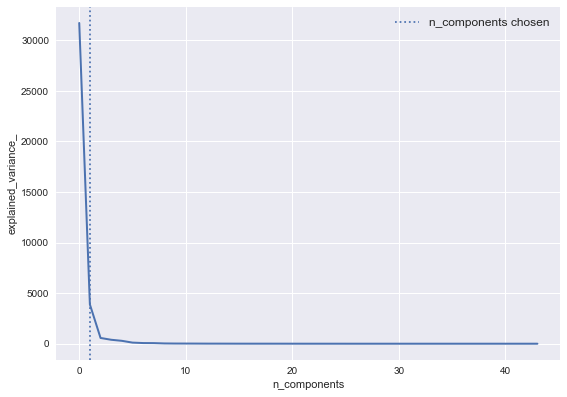

In [444]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[("scaler", StandardScaler()),('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = matchstats["Home"] - matchstats["Away"]
y_digits = identifier[dependent]

# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(10, 7))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [1, 5, 10]
#Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,dict(pca__n_components=n_components))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()


In [542]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

%matplotlib inline

gaus = GaussianNB()
#lreg = linear_model()
#svm = svm.LinearSVR()
models = [("Gauss", GaussianNB()),("lreg", linear_model.LinearRegression()) ,("svm", svm.LinearSVC()), ("Forest",RandomForestClassifier())]

In [543]:
seed = 8
kfold = KFold(n_splits=5, random_state=seed)
all_results = []
all_pipes = []
for model in models:
    pipe= Pipeline([("scale", StandardScaler()),model])
    all_pipes.append(pipe)
    
    #model=pipe.fit(X,Y)
    results = cross_val_score(pipe, X, Y, cv=kfold)
    all_results.append(results)

[array([ 0.45901639,  0.43442623,  0.48770492,  0.43032787,  0.44262295]),
 array([ -4.33808135e+17,  -2.66496980e-02,  -1.66406892e-02,
         -5.93875682e-02,  -2.96924415e-02]),
 array([ 0.44672131,  0.47540984,  0.5       ,  0.50819672,  0.49180328]),
 array([ 0.40983607,  0.43442623,  0.38934426,  0.4795082 ,  0.43442623])]

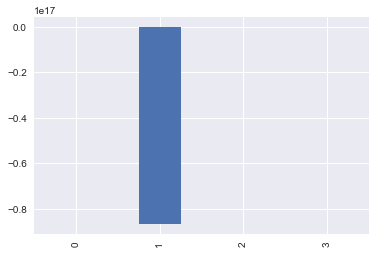

In [545]:
pd.DataFrame(all_results).T.mean().plot(kind = "bar")
all_results

In [546]:
logreg = all_pipes[1]

In [547]:
model = logreg.named_steps["lreg"]

In [551]:
model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [552]:
model.coef_

array([  2.99609078e+11,   1.21479034e-02,  -1.79765447e+11,
        -1.79765447e+11,  -1.19843631e+11,  -1.19843631e+11,
        -1.19843631e+11,   4.21310425e-01,  -1.21466064e+00,
         7.58527641e+01,   7.58452797e+01,  -7.78198242e-04,
         4.18853760e-03,   2.27813721e-02,   1.68304443e-02,
         6.57272339e-03,  -8.48865509e-03,  -8.39042664e-03,
         8.24928284e-05,   1.10626221e-04,   1.83105469e-04,
         1.19405985e-02,  -1.01410627e-01,   3.67209256e+00,
        -2.44100571e-01,  -9.60445404e-03,   1.85394287e-03,
        -1.13436818e-01,   5.52358627e-02,  -1.32839173e-01,
         5.53069115e-02,  -2.24294662e-02,  -3.44657898e-03,
        -1.42478943e-02,   8.85009766e-04,  -1.81608200e-02,
         2.38037109e-03,  -8.10623169e-05,   1.66408867e+00,
        -5.45501709e-04,  -1.33514404e-04,  -3.24249268e-03,
         4.42504883e-04,   3.15856934e-03])

In [7]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [17]:
lreg = linear_model.LinearRegression()
rfecv = RFECV(estimator=lreg, step=1, cv=KFold(10),
              scoring='r2')
rfecv.fit(X, Y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='r2', step=1, verbose=0)

Optimal number of features : 37


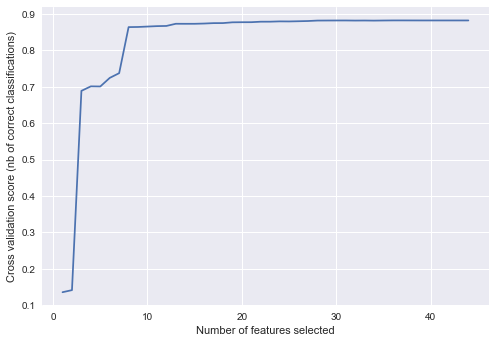

In [18]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
X.columns[(rfecv.ranking_ == 1)]

Index(['shotstotal', 'shotsongoaltotal', 'shotstotaloutsidebox',
       'shotstotalinsidebox', 'shotsfootoutsidebox', 'shotsfootinsidebox',
       'shotstotalheader', 'chancenverwertung', 'chancen_inside',
       'passescompletedpercent', 'passesfailedpercent', 'passescompleted',
       'passesfailed', 'cornerkicks', 'cornerkicksright', 'crosses',
       'fastrunsdistance', 'intensiverunsdistance', 'averagespeed', 'speed',
       'distance', 'sprintsdistance', 'yellowcards', 'redcards',
       'yellowredcards', 'offsides', 'foulscommitted', 'ballstouchedpercent',
       'ballstouched', 'duelswonpercent', 'duelswon', 'activeplayercount',
       'saison_platz', 'saison_punkte', 'saison_tordiff', 'saison_tore',
       'saison_gegentore'],
      dtype='object')

In [114]:
from sklearn.feature_selection import SelectFromModel
%matplotlib inline
lsvc = linear_model.LogisticRegression().fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
#X_new = model.transform(X)
#X_new.shape

In [115]:
idx = model.get_support()
X.columns[idx]

Index(['chancenverwertung', 'chancen_inside', 'fastrunsdistance',
       'intensiverunsdistance', 'averagespeed', 'sprintsdistance', 'redcards',
       'yellowredcards', 'activeplayercount'],
      dtype='object')

In [131]:
df = X.loc[:,idx]
((df.corr() > 0.7) & (df.corr() != 1.0)).sum().sum()

4

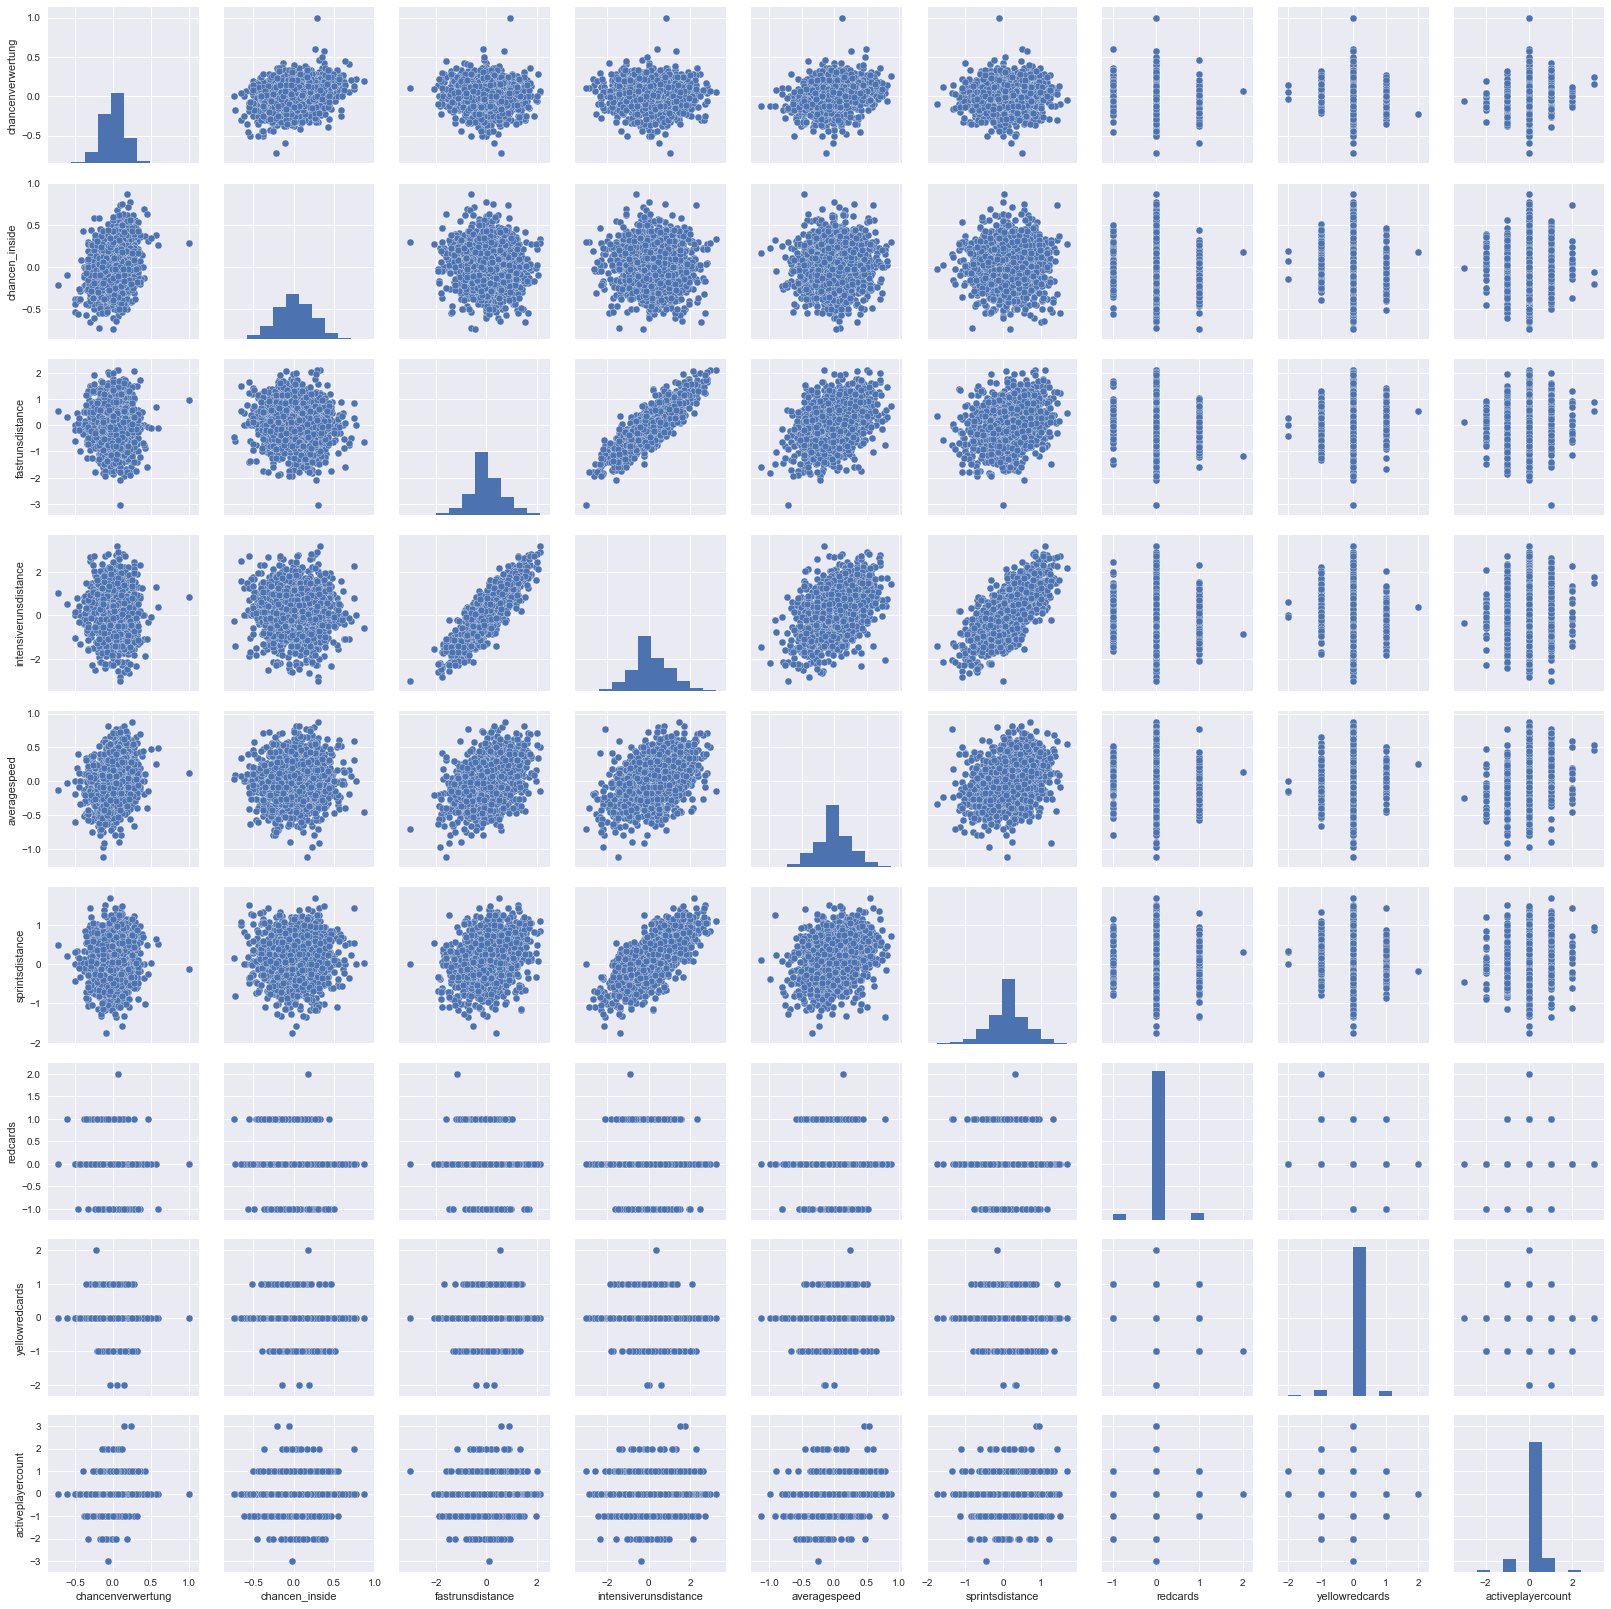

In [116]:
sns.pairplot(X.loc[:,idx])

In [80]:
for col in X_new.columns:
    if X.isin(X_new[col]).all() == True:
        print(col) 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [77]:
len(X), len(X_new)

(1826, 1826)

In [61]:
df1 = pd.DataFrame({"Tiere":["Hund","Katze","Hase"]*12,"Größe":[2,3,4]*12, "Gewicht":[10,24,13]*12})
df2 = pd.DataFrame({"Test":["Hund","Katze","Hase"]*12})

In [74]:
for col in df1.columns:
    _ = df2.isin(df1[col]).sum()
    print(_)

Test    0
dtype: int64
Test    0
dtype: int64
Test    36
dtype: int64


In [48]:
np1 = np.array(df1)
np2 = np.array(df2)

In [49]:
np2 == np1

/Users/Felix/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


False

In [55]:
np2

array([['Hund'],
       ['Katze'],
       ['Hase']], dtype=object)

In [67]:
list(df2.values)

[array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object),
 array(['Katze'], dtype=object),
 array(['Hase'], dtype=object),
 array(['Hund'], dtype=object)